## Predicting Heart Disease


### Introduction:

Heart disease is an umbrella term for a vast range of conditions that affect the heart. While there are many leading causes that can contribute to higher risks to heart disease, unhealthy lifestyle choices and genetics often play a large role. Based on a dataset from 1988 consisting of 4 databases, Cleveland, Hungary, Switzerland, and Long Beach V, trends relating to heart disease will be used to predict the presence of it in individuals. Five attributes will be observed in order to successfully determine the presence of heart disease in a patient. Using the method of K-nearest neighbours classification, the question of "Can heart disease in a patient be predicted prior to diagnoses using data on age, exercise induced angina, serum cholesterol levels and resting blood pressure?".

### Methods and Results:
** describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
your report should include code which:
loads data from the original source on the web 
wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 
note: all tables and figure should have a figure/table number and a legend **

To begin our analysis we first loaded in some of the libraries that we would likely be using. Then, using read_csv, we first read in our dataset to better explore the variables and their relationship to the "target" variable, indicating the absence of heart disease, 0, and the presence of heart disease, 1. We then selected the predictors we wanted to use and checked if there were mission values in the data set using the "sum(is.na())" function.

In [2]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(GGally)


heart_data <- read_csv("project_data/heart.csv")
slice(heart_data, 1:5)
heart_var <- heart_data |>
    select(age, exang, chol, thalach, trestbps, target)
slice(heart_var, 1:5)
sum(is.na(heart_data))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


age,exang,chol,thalach,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,0,212,168,125,0
53,1,203,155,140,0
70,1,174,125,145,0
61,0,203,161,148,0
62,0,294,106,138,0


[1] 0

From here, we split the data with the seleced variables into a training set with 75% of the data, and a testing set with 25% of the data. To make sure the data is reproducible, we will be using 3456 as our seed number.

In [3]:
set.seed(3456)

heart_split <- initial_split(heart_var, prop = 0.75, strata = target)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

slice(heart_train, 1:5)

age,exang,chol,thalach,trestbps,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53,1,203,155,140,0
70,1,174,125,145,0
61,0,203,161,148,0
46,0,249,144,120,0
43,1,341,136,132,0


To better understad the relationships between the variables, we chose to use box plots. In this way, we can see the mean values for variables where there is a presence of heart disease, when target is 1, and when there is no heart disease, when the target is zero. Since the target variable only has two possible values, we decided to plot target on the x-axis.

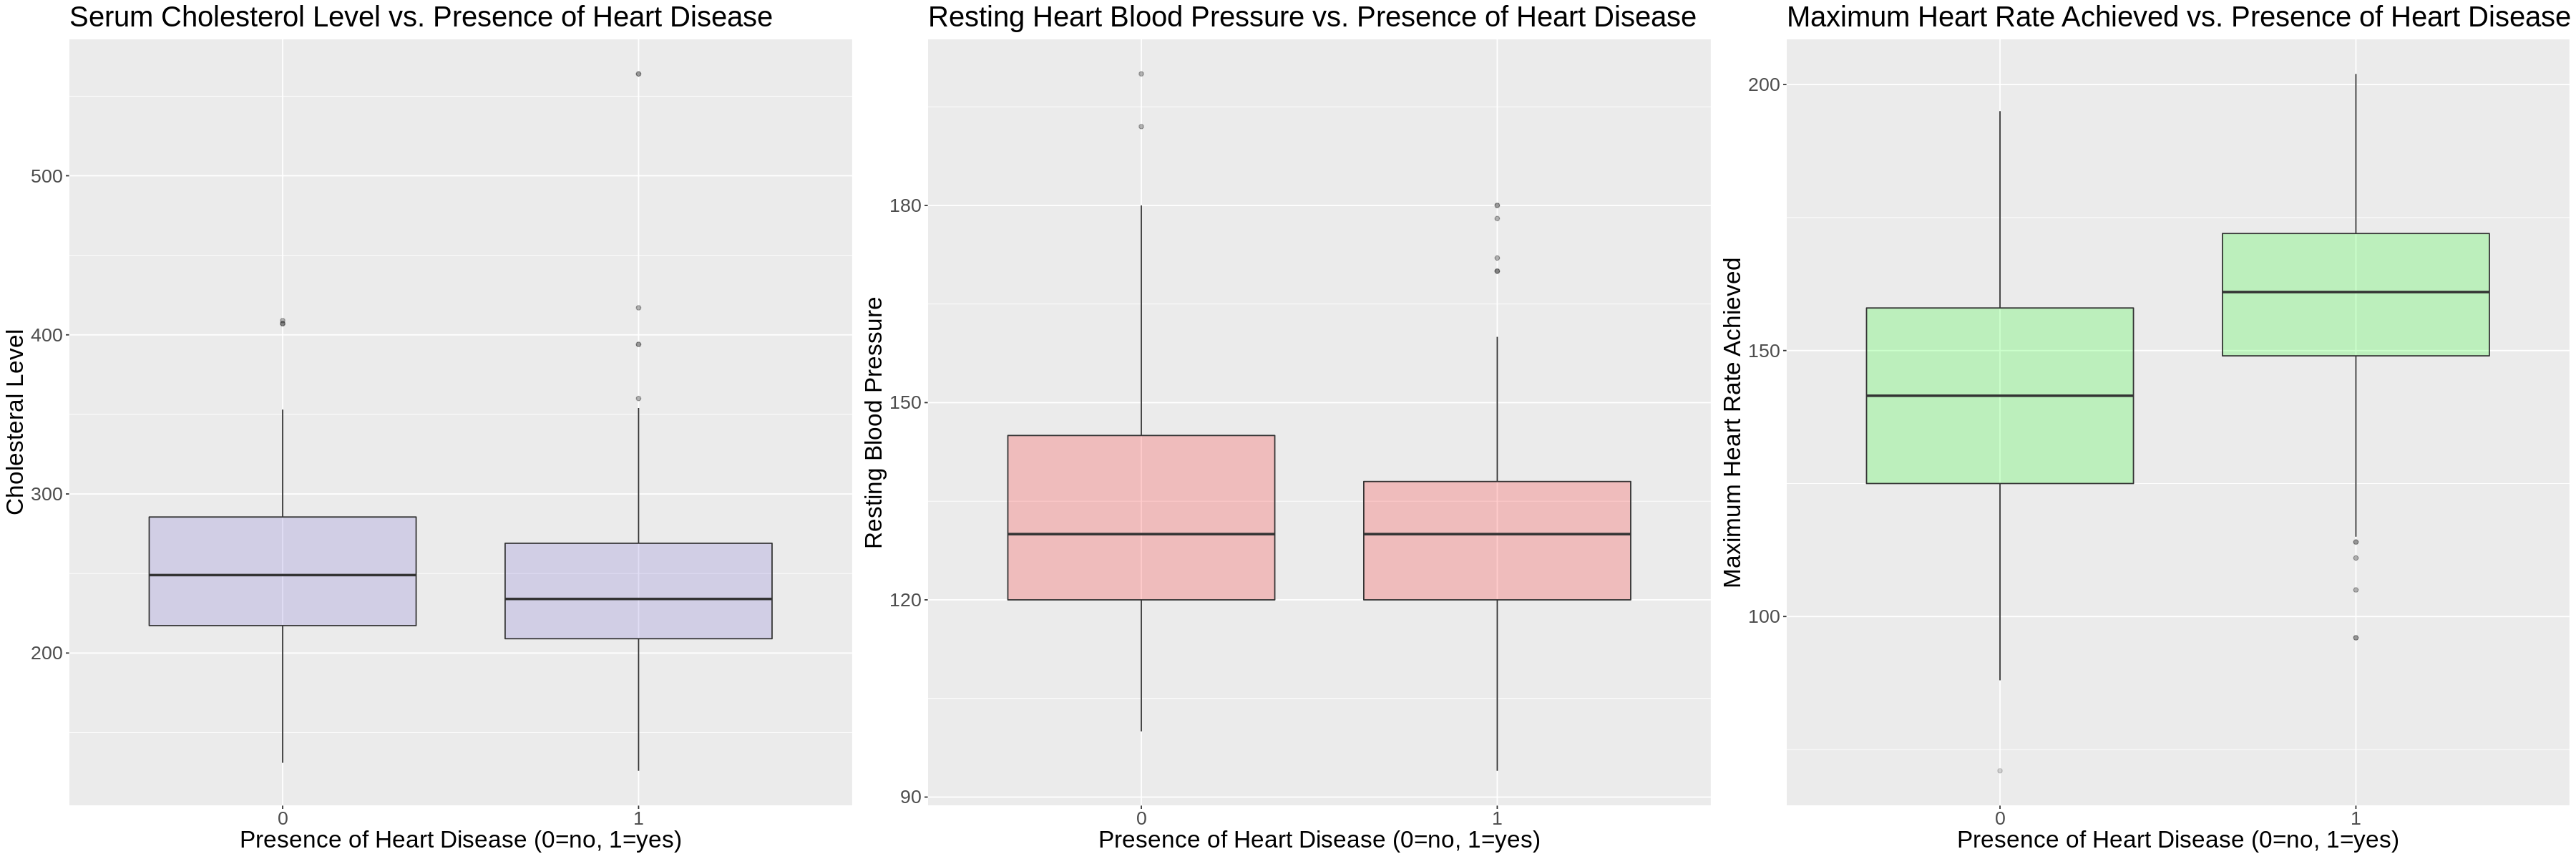

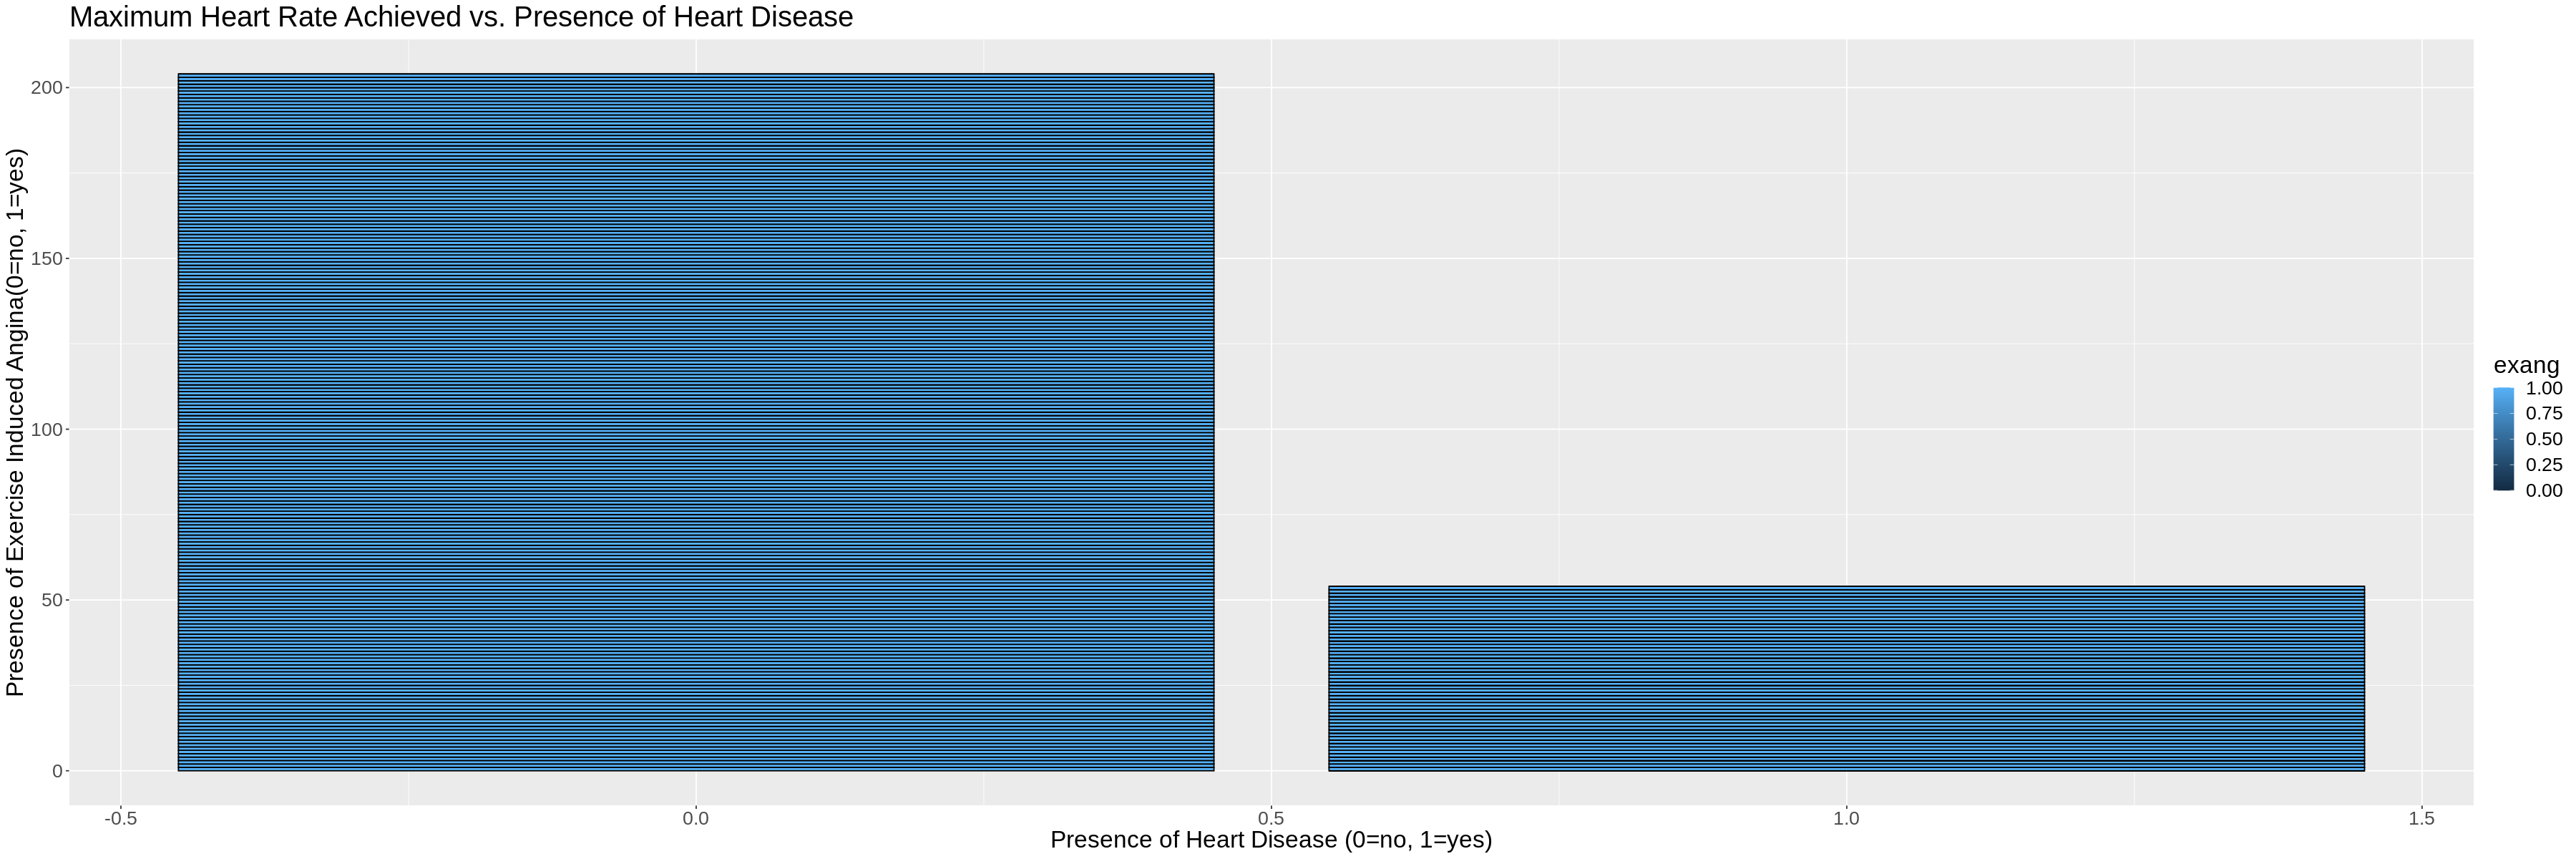

In [21]:
options(repr.plot.width = 30, repr.plot.height = 10)
chol_plot <- ggplot(heart_train, 
     aes(y = chol, 
           x = as.factor(target))) +
     geom_boxplot(fill = "slateblue", alpha = 0.2)+
     labs(x = "Presence of Heart Disease (0=no, 1=yes)", y = "Cholesteral Level" )+
     theme(text = element_text(size = 20))+
     ggtitle("Serum Cholesterol Level vs. Presence of Heart Disease")

trestbps_plot<- ggplot(heart_train,
    aes(y = trestbps,
            x = as.factor(target))) +
    geom_boxplot(fill = "red", alpha = 0.2)+
    labs(x="Presence of Heart Disease (0=no, 1=yes)", y = "Resting Blood Pressure" )+
    theme(text = element_text(size = 20))+
    ggtitle("Resting Heart Blood Pressure vs. Presence of Heart Disease")

grid.arrange(chol_plot, trestbps_plot, thalach_plot, ncol = 3)

age_plot<- ggplot(heart_train,
        aes(y = age,
            x = as.factor(target))) +
    geom_boxplot(fill = "purple", alpha = 0.2)+
    labs(x = "Presence of Heart Disease (0=no, 1=yes)", y = "Age" )+
    theme(text = element_text(size = 20))+
    ggtitle("Age vs. Presence of Heart Disease")
       

thalach_plot <- ggplot(heart_train,
        aes(y = thalach,
            x = as.factor(target))) +
    geom_boxplot(fill = "green", alpha = 0.2)+
    labs(x = "Presence of Heart Disease (0=no, 1=yes)", y = "Maximum Heart Rate Achieved" )+
    theme(text = element_text(size = 20))+
    ggtitle("Maximum Heart Rate Achieved vs. Presence of Heart Disease")




exang_plot <- ggplot(heart_train, aes(x = target, y = exang, fill = exang ))+
   geom_bar(stat = "identity", position = "stack", color = "black")+
   labs(x = "Presence of Heart Disease (0=no, 1=yes)", y = "Presence of Exercise Induced Angina(0=no, 1=yes)")+
   theme(text = element_text(size = 20))+
   ggtitle("Exercise Induced Angina vs. Presence of Heart Disease")
exang_plot

Looking at the above plots for serum cholesterol level, it can be seen the mean levels for individuals with heart disease is slightly lower than the mean cholesterol levels for individuals who do not have heart disease. This is slightly surprising as, the general trend found through research is that higher serum cholesterol levels tends to increase risks of developing heart disease. Regarding resting blood pressure, there was not a large difference in the mean values between individuals with heart disease. From this graph alone, there is a suggestion that there is not a strong correlation between the presence of heart disease, and high or low resting blood pressure values. In reference to the maximum heart rate achieved, there is a higher mean value for individuals with a presence of heart disease. This is supported by research which suggests that a higher resting heart rate could indicate an increased risk of developing heart disease.

### Discussion:
** summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to? **

### References:
** At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well. **